프로젝트: 캐글  
  
  
노드 본문에서는 하이퍼 파라미터를 조정하는 방식으로 모델 성능을 끌어올리는 것을 생각하는듯  
  
주로 사용하는 lightgbm 인자(이것들은 실험해볼 것)  
max_depth, learning_rate, n_estimators, num_leaves, boosting_type  
시도방법(힌트?)  
feature engineering(데이터 가공), 다양한 모델(LGBMRegressor, XGBRegressor, RandomForestRegressor 등 튜닝하기), 다양한 하이퍼 파라미터에 대한 그리드 탐색, 블렌딩  
  
대회 진행자들의 커널  
https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks

루브릭  
데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?(데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 만든 csv파일을 캐글 My submission까지 진행했고, submission 결과를 이미지로 제출하였다.)  
제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?( 제출한 주피터노트북 파일이 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.)  
다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가? (다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score기준 110000이하의 점수를 얻었따.)

### 전처리
데이터 관측, 결측값, 중복값 확인, log변환, one-hot-encoding 형식으로 변환 등 수행

In [1]:
# 필요 import
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import sklearn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 경로 설정
data_dir='.\ess_data\house_price_kaggle'
train_data_path= os.path.join(data_dir, 'train.csv')
sub_data_path= os.path.join(data_dir, 'test.csv')

In [3]:
# csv 읽기
train_data=pd.read_csv(train_data_path, index_col='id')
sub_data= pd.read_csv(sub_data_path, index_col='id')

In [4]:
# 데이터 둘러보기
train_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  object 
 1   price          15035 non-null  float64
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

데이터를 둘러본 다음 가장 먼저 할 일은 결측값과 중복값의 존재 여부이다.

In [6]:
# 결측치 확인하기
print(train_data.isnull().sum(),'\n')
print(sub_data.isnull().sum())

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64 

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [7]:
# 중복행 확인하기
train_data.duplicated()[train_data.duplicated()==True]

Series([], dtype: bool)

데이터를 파악함에 앞서, test_data와 sub_data를 병합하여 확인하지는 않았다.  
둘을 병합할 이유가 있다면 데이터가 고르게 분포되어 있지 않을 가능성 때문이라고 생각하는데, 
분포가 고르지 않다고 하더라도 competition에서는 train dataset과 test dataset을 각각의 목적에 맞게 사용하도록 지정하고 있다. 병합하여 더 좋은 insight를 얻을 수 있다고 해도 학습에 사용할 train data와 테스트에 사용할 test data가 한쪽으로 쏠려있는 것은 마찬가지고, 병합 데이터에서 insight를 얻는다 하더라도 모델에 적절하게 적용시키기 어렵다고 생각하기 때문이다.  
쉽게 말하면, train과 test data의 역할이 명확하게 정해진 상태에서 두 데이터의 분포가 모집단을 대표하지 못한다면 뭘 해도 안되기 때문에 굳이 병합하여 분석하지 않겠다는 말이다.  
왜 지금까지 본 문제들이 train용과 test용으로 데이터를 나눠서 주지 않았는지 되세기게 되었다. 데이터가 고르게 분포되도록 train과 test로 나누는 것도 실력이니까.

In [8]:
# 데이터 변형: data 불필요한 부분 절삭
train_data['date'] = train_data['date'].apply(lambda x : str(x[:6]))
train_data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509


In [9]:
sub_data['date'] = sub_data['date'].apply(lambda x : str(x[:6]))
sub_data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
15035,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
15036,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
15037,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
15038,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
15039,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265


데이터들의 형상을 확인한다.

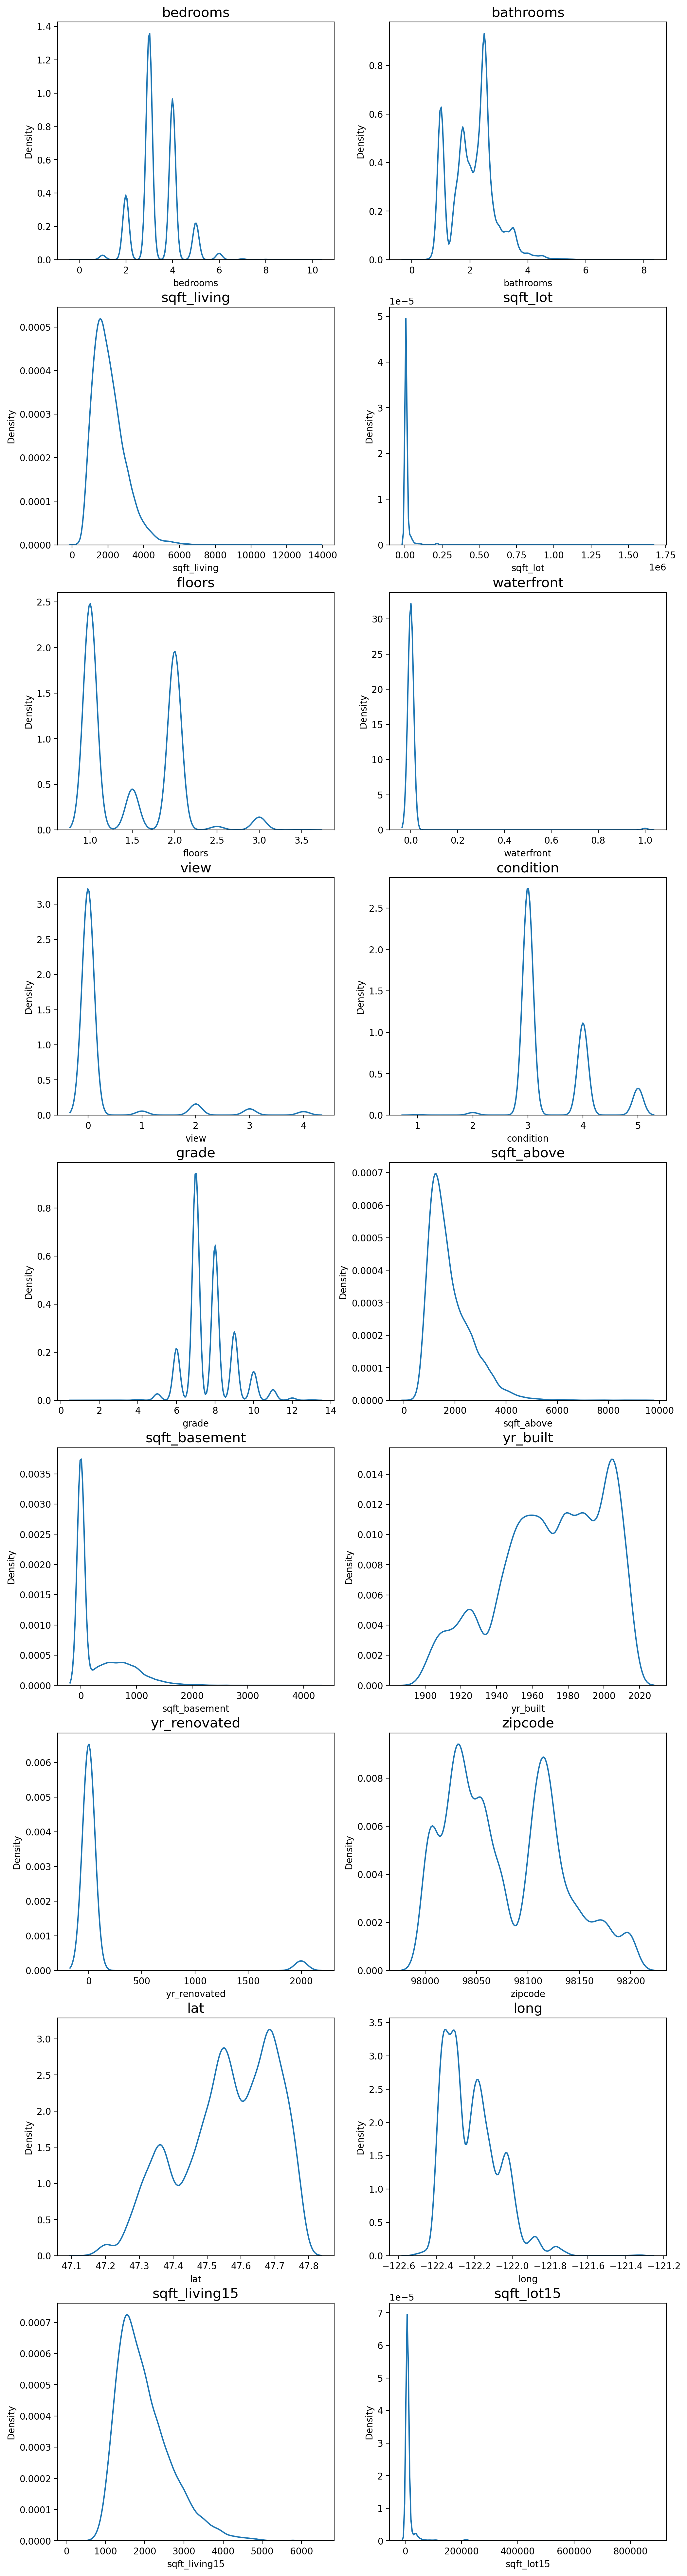

In [10]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 2
columns = train_data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train_data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

bederooms, bathrooms, sqft_living, sqft_lot, view, sqft_above, sqft_basement, sqft_living15, sqft_lot15에 대해 log를 적용하는 편이 좋을 것 같다. 하지만 log 적용을 결정하기 전에 위의 값들 중 one-hot-encoding 대상이 되는 값이 있다면 log를 취하는 대신 제외하는 것이 맞다고 생각되어 one-hot-encoding 대상을 확인해 보기로 하였다.  

몇몇 의심 column들의 값들을 확인해 보았다.

In [11]:
print('number of bedroom:', set(train_data['bedrooms']))
print('number of bathroom:', set(train_data['bathrooms']))
print('floors:', set(train_data['floors']))
print('waterfront:', set(train_data['waterfront']))
print('view:', set(train_data['view']))
print('condition:', set(train_data['condition']))
print('grade:', set(train_data['grade']))
print('yr_built:', set(train_data['yr_built']))
print('yr_renovated:', set(train_data['yr_renovated']))
print('zipcode:', set(train_data['zipcode']))

number of bedroom: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
number of bathroom: {0.75, 1.0, 2.5, 2.0, 2.25, 1.5, 1.75, 3.0, 2.75, 3.25, 4.0, 3.5, 4.75, 5.0, 5.25, 6.0, 3.75, 8.0, 4.25, 4.5, 5.5, 5.75, 1.25, 0.5, 6.75, 0.0, 6.25, 7.5, 7.75}
floors: {1.0, 2.5, 2.0, 3.0, 1.5, 3.5}
waterfront: {0, 1}
view: {0, 1, 2, 3, 4}
condition: {1, 2, 3, 4, 5}
grade: {1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
yr_built: {1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 

이 중 어떤 값에 one-hot-encoding을 적용시켜야 하는지가 가장 큰 고민이었다. 식견이 부족하여 완벽하게 정할 수 없지만, 위의 데이터들은 모두 이산적인 값을 가지고 있다.  
그렇다면 이산적이면 모두 one-hot encoding 대상이어야 하는가?   
이에 대한 명확한 대답을 찾기 어려웠다. 그래서 검색하면서 알게 된 약간의 지식들을 조합하여 one-hot-encoding을 적용하는데 나름의 기준을 정하기로 했다.  
1. column의 원소들은 이산적인가?  
만약 원소들이 이산적이지 않다면 2.로 넘어간다.
2. 원소들끼리 더하거나 뺄때 계산 결과를 같은 방식으로 해석이 안 되는가?  
2번 조건의 예를 들자면, bedroom의 원소 1과 2를 더하면 3이 되는데, 3은 bedroom의 개수가 3개라는 의미이기 때문에 계산 결과가 같은 방식으로 해석이 되는 것이고, zipcode의 경우 더한다고 다른 zipcode가 되지 않기 때문에 셈을 한다고 같은 방식으로 해석이 되지 않는다고 본다. 연산시 같은 방식으로 해석이 되지 않는다면 정상적인 학습이 이루어지기 어려울 것으로 생각되어 위 2개의 조건을 만족하는 column에 대해 one-hot-encoding을 진행하였고, 개중 log변환 대상이 있다면 log변환은 생략하였다.  
그 결과, 다음과 같이 정리하게 되었다.  
log변환 column: bederooms, bathrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15  
one-hot-encoding변환 column: view, condition, grade, yr_built, yr_renovated, zipcode  
* waterfront는 이미 one-hot-encoding이라 제외하였다

In [12]:
# log화 및 그 결과 그래프로 확인
skew_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train_data[c] = np.log1p(train_data[c].values)
    sub_data[c] = np.log1p(sub_data[c].values)

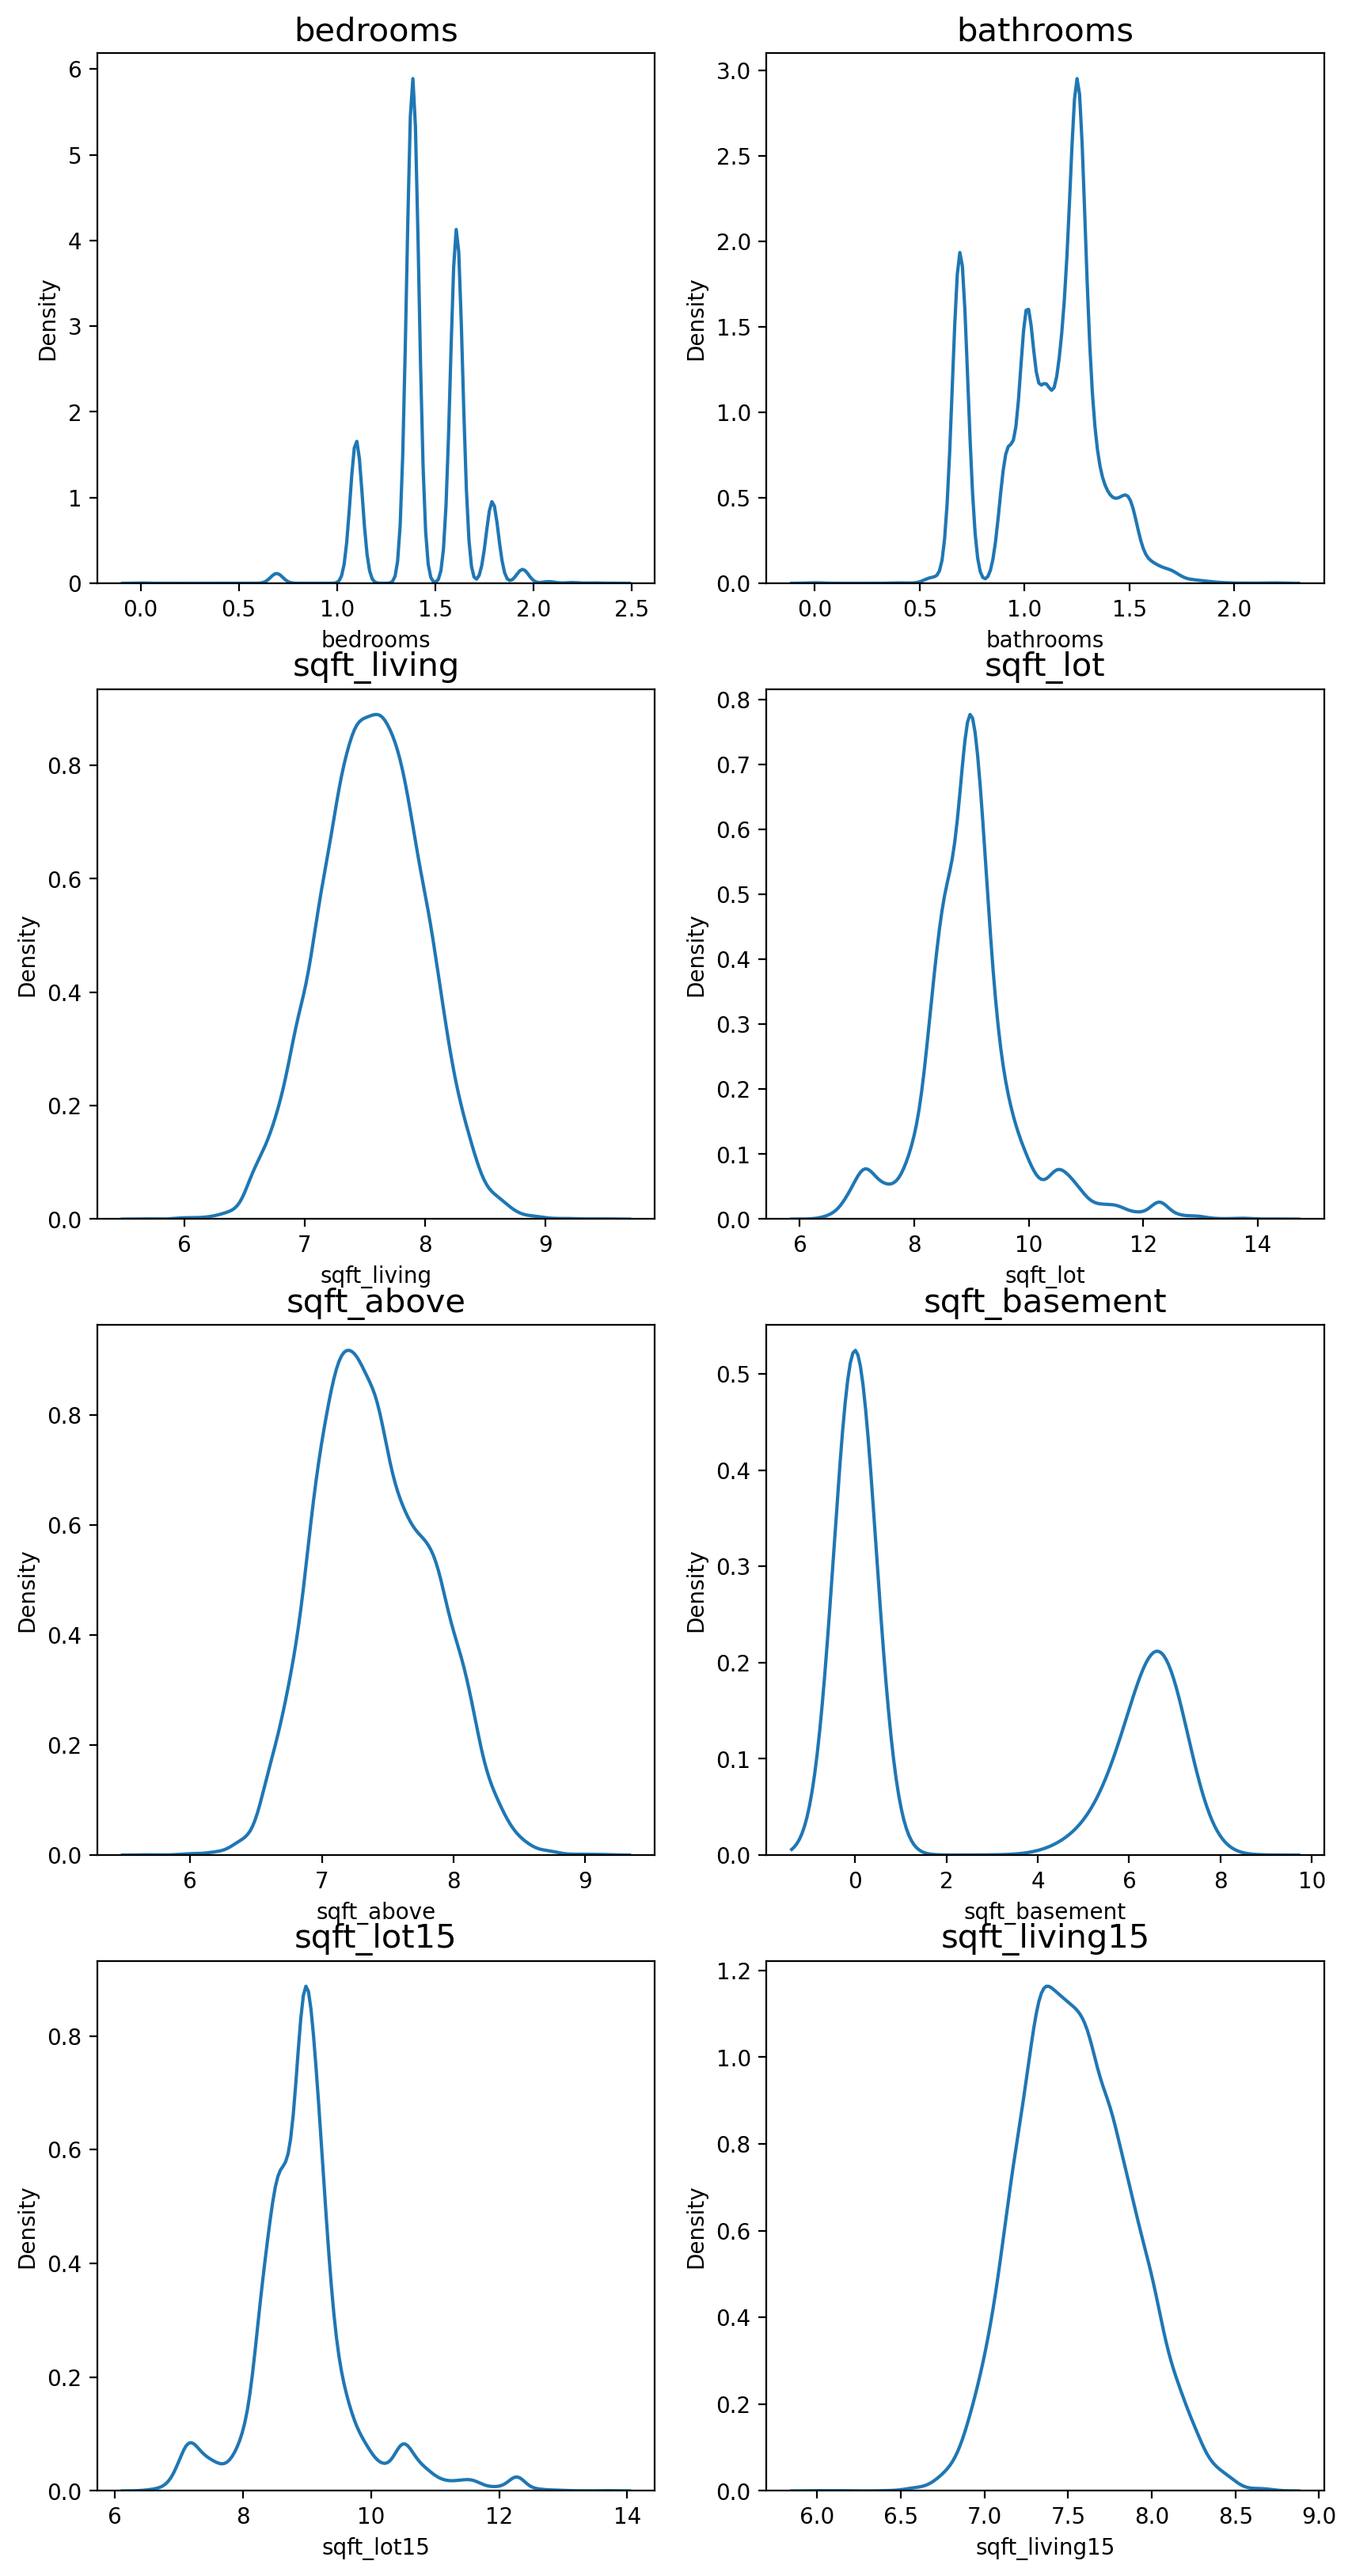

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
count = 0
columns = skew_columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=train_data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 8 :
            break

In [14]:
# 'yr_renovated', 'grade',  일시 제거(test 값에 train에 있는 몇몇 값이 존재하지 않아 학습에 문제가 생김)
one_hot={'view', 'condition', 'yr_built', 'zipcode'} 
train_data=pd.get_dummies(train_data, columns=one_hot)

print(train_data)

         date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                             
0      201410   221900.0  1.386294   0.693147     7.074117  8.639588     1.0   
1      201502   180000.0  1.098612   0.693147     6.647688  9.210440     1.0   
2      201502   510000.0  1.386294   1.098612     7.427144  8.997271     1.0   
3      201406   257500.0  1.386294   1.178655     7.447751  8.827615     2.0   
4      201501   291850.0  1.386294   0.916291     6.966967  9.181118     1.0   
...       ...        ...       ...        ...          ...       ...     ...   
15030  201410   610685.0  1.609438   1.252763     7.832411  8.703507     2.0   
15031  201503  1007500.0  1.609438   1.504077     8.163656  8.881975     2.0   
15032  201405   360000.0  1.386294   1.252763     7.333676  7.031741     3.0   
15033  201502   400000.0  1.609438   1.252763     7.745436  8.668024     2.0   
15034  201410   325000.0  1.098612   0.5

In [15]:
sub_data=pd.get_dummies(sub_data, columns=one_hot)
sub_data

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,...,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,condition_1,condition_2,condition_3,condition_4,condition_5
id,,,,,,,,,,,,,,,,,,,,,
15035,201412,1.386294,1.178655,7.852050,8.887791,2.0,0,7,7.682943,5.993961,...,0,0,0,0,0,0,0,1,0,0
15036,201412,1.609438,1.386294,7.581210,8.517393,1.0,0,7,6.957497,6.814543,...,0,0,0,0,0,0,0,0,0,1
15037,201405,1.609438,1.704748,8.598036,11.532051,1.0,0,11,8.266421,7.333676,...,0,0,0,0,0,0,0,1,0,0
15038,201504,1.386294,0.693147,7.484930,8.918784,1.0,0,7,6.957497,6.594413,...,0,0,0,0,0,0,0,1,0,0
15039,201503,1.386294,1.252763,7.544861,8.788898,2.0,0,7,7.544861,0.000000,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,1.386294,1.011601,7.313887,9.390075,1.0,0,6,7.313887,0.000000,...,0,0,0,1,0,0,0,1,0,0
21499,201501,1.386294,1.098612,7.307202,7.027315,3.0,0,8,7.307202,0.000000,...,0,0,0,1,0,0,0,1,0,0
21500,201502,1.386294,1.252763,7.178545,7.166266,2.0,0,8,7.074117,4.875197,...,0,0,0,0,0,0,0,1,0,0


In [16]:
y=train_data['price']
del train_data['price']

이제 준비는 끝났다.
### 학습
기본적으로 gboost, xgboost, lightgbm을 블렌딩하여 averaging을 사용하여 정확도를 높힌다.

In [17]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [18]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train_data.values) # 5등분으로 나누어 검증
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train_data.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [19]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8614
Model: XGBoost, CV score:0.8899
Model: LightGBM, CV score:0.8817


In [20]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([ #배열 붙이기
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [21]:
for i in train_data.columns:
    if i not in sub_data.columns:
        print(i)

In [22]:
y_pred = AveragingBlending(models, train_data, y, sub_data)
print(len(y_pred))
y_pred

6468


array([ 533435.95010781,  461996.74101536, 1364207.27634203, ...,
        448994.8458881 ,  330955.60233457,  434357.93953932])

In [23]:
result= pd.DataFrame({
    'id': sub_data.index,
    'price': y_pred
})

In [24]:
submission_path='.\\ess_data\\house_price_kaggle\\submission.csv'
result.to_csv(submission_path, index=False)

제출 결과 점수는  
private score: 115812.48548  
public score: 115618.8335 였다. 혹시 몰라 약간의 입력 데이터를 조정해 봤지만 큰 성과는 없었다. 그래서 하이퍼 파라미터 튜닝 및 블렌딩할 모델을 추가하여 모델을 발전시키기로 결정했다.  
또한, 위와 같은 데이터로 튜닝을 이어가려 하였으나 모델 학습시 오류를 잡지 못해 다시 한번 전체적인 재정비를 할 수 밖에 없었다.(데이터 초기화 등은 노드를 그대로 따라간다.)

In [25]:
# 경로 설정
data_dir='.\ess_data\house_price_kaggle'
train_data_path= os.path.join(data_dir, 'train.csv')
test_data_path= os.path.join(data_dir, 'test.csv')

# csv 읽기
train=pd.read_csv(train_data_path)
test= pd.read_csv(test_data_path)

상관분석을 추가로 진행하였다.

In [26]:
train.corr().loc[['price']]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,0.020899,1.0,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.03974,0.667211,0.608577,0.322218,0.04729,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384


상관분석 결과, +-0.1 이하의 column들(sqft_lot, condition, yr_built, zipcode, long, sqft_lot15)를 제외하였다.

In [27]:
# date 값 조정
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
# price값 다른 곳에 저장하고 원래 데이터에서는 지우기
y = train['price']
del train['price']
# id 지우기
del train['id']
# 상관계수 조건에 맞지 않는 column 삭제
# del train['sqft_lot']
# del train['condition']
# del train['yr_built']
del train['zipcode']
del train['long']
# del train['sqft_lot15']

# test에도 date변환, id삭제
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']
# 상관계수 조건에 맞지 않는 column 삭제
# del test['sqft_lot']
# del test['condition']
# del test['yr_built']
del test['zipcode']
del test['long']
# del test['sqft_lot15']

one_hot={'view', 'condition', 'yr_built'} #, 'zipcode'
train=pd.get_dummies(train, columns=one_hot)
test=pd.get_dummies(test, columns=one_hot)

In [28]:
# y정규분포화를 위해 log를 씌움
y = np.log1p(y)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [30]:
# 모델 평가를 위한rmse 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [31]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [32]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [33]:
#데이터를 학습시키고 그 결과를 rmse로 출력
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. -> 굳이 루프 안에 해주는 이유는?
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)
        
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

In [34]:
from sklearn.model_selection import GridSearchCV

LGBM은 tree 기반 모델로, 데이터의 수가 많을 때 위력을 발휘하는 모델로 알려져 있다. LGBM의 대표적인 하이퍼 파라미터는 max_depth, learning_rate, n_estimators, num_leaves, boosting_type 등이 있으며, 이러한 파라미터들에 대한 테스트를 해 보았다.

In [35]:
model = LGBMRegressor(random_state=random_state)
param_grid = {
   'n_estimators': [100, 150], # tree를 반복 수행하는 트리의 수 
   'max_depth': [10, 15], # tree의 깊이(level) 
   'learning_rate': [0.1, 0.05], # 모델의 학습률
   'boosting_type': ['gbdt','goss', 'dart'], # 알고리즘의 종류, ,'rf', 'dart' 제거
   'num_leaves': [26, 31, 36] # 잎사귀 node의 수 , 21
   
    # 'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    # 'n_estimators': [50, 100, 150],
    # 'max_depth': [1,10,20]
    
}

In [36]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'boosting_type': ['gbdt', 'goss', 'dart'],
                         'learning_rate': [0.1, 0.05], 'max_depth': [10, 15],
                         'n_estimators': [100, 150],
                         'num_leaves': [26, 31, 36]},
             scoring='neg_mean_squared_error', verbose=1)

In [37]:
params=grid_model.cv_results_['params']

In [38]:
grid_model.cv_results_['mean_test_score']

array([-0.03561499, -0.03558454, -0.03532354, -0.03532335, -0.0353399 ,
       -0.03515614, -0.03552795, -0.03550629, -0.03518239, -0.03515638,
       -0.03526139, -0.03501388, -0.03692785, -0.03668451, -0.03636661,
       -0.03567827, -0.03552338, -0.0353252 , -0.03693021, -0.03659679,
       -0.03623182, -0.03570355, -0.03544315, -0.03526112, -0.03579561,
       -0.03588941, -0.03602615, -0.03550657, -0.03575018, -0.03612993,
       -0.03566334, -0.03596434, -0.03591508, -0.03559943, -0.03604267,
       -0.03584637, -0.0367177 , -0.03644774, -0.03634037, -0.03559735,
       -0.03555261, -0.03542765, -0.03660799, -0.03639913, -0.03623074,
       -0.03562037, -0.03545149, -0.03544456, -0.64700462, -0.64696323,
       -0.64667897, -0.33230786, -0.33257953, -0.33192525, -0.64703095,
       -0.64706657, -0.64728011, -0.33222921, -0.33262242, -0.33257031,
       -2.41620337, -2.41555367, -2.41481613, -2.16302043, -2.16264934,
       -2.16219055, -2.41647007, -2.41561042, -2.41498761, -2.16

In [39]:
results=pd.DataFrame(params)
results['score']=grid_model.cv_results_['mean_test_score']
results['RMSLE'] = np.sqrt(-1 * results['score']) # 점수를 RMLSE로 변환한다.
print(results.sort_values('RMSLE'))

   boosting_type  learning_rate  max_depth  n_estimators  num_leaves  \
11          gbdt           0.10         15           150          36   
5           gbdt           0.10         10           150          36   
9           gbdt           0.10         15           150          26   
8           gbdt           0.10         15           100          36   
23          gbdt           0.05         15           150          36   
..           ...            ...        ...           ...         ...   
68          dart           0.05         15           100          36   
61          dart           0.05         10           100          31   
67          dart           0.05         15           100          31   
60          dart           0.05         10           100          26   
66          dart           0.05         15           100          26   

       score     RMSLE  
11 -0.035014  0.187120  
5  -0.035156  0.187500  
9  -0.035156  0.187500  
8  -0.035182  0.187570  
23 -0.0352

가장 점수가 좋았던 하이퍼 파라미터는  
boosting_type='gbdt'  
learning_type=0.1  
max_depth=10  
n_estimators=200  
num_leaves=31(default값)  
이었고, score=-0.026188, RMSLE=0.161828였다. 위에 작성된 코드 외에도 여러번 반복하였지만 더 개선시킬 수는 없었다. 또한, 경고 메세지가 뜨는데 이는 boosting_type(알고리즘)에 적합하지 않은 하이퍼 파라미터가 입력되면 경고 메시지가 발생하는 것으로 보이며, 해당 값들은 NaN 처리되었다. 처음에는 이 값들을 어떻게든 제거하려 했지만, 차라리 많은 시행을 하고 NaN값이 나오는 파라미터들은 무시하면서 진행하는 것이 더 효율적인 알고리즘을 찾는데 도움이 되는 것 같아 무시하고 가장 점수가 높은 하이퍼 파라미터 조합을 탐색하였다.  
마지막으로 해당 파라미터들을 적용하여 예측을 시도하였다.

In [40]:
# num_leaves=31은 default 값이니 생략
model = LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, max_depth=10, n_estimators=200, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)

In [41]:
submission_path ='.\\ess_data\\house_price_kaggle\\submission.csv'
submission = pd.read_csv(submission_path)
submission.head()

# submission_path='.\\ess_data\\house_price_kaggle\\submission.csv'
# result.to_csv(submission_path, index=False)

,id,price
0,15035,5.334360e+05
1,15036,4.619967e+05
2,15037,1.364207e+06
3,15038,3.416799e+05
4,15039,3.092881e+05


In [42]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.317914e+05
1,15036,3.616821e+05
2,15037,1.406070e+06
3,15038,3.149882e+05
4,15039,3.108958e+05


In [43]:
submission_csv_path ='.\\ess_data\\house_price_kaggle\\submission_{}_RMSLE_{}.csv'.format('lgbm', '0.161828')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

.\ess_data\house_price_kaggle\submission_lgbm_RMSLE_0.161828.csv


In [44]:
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,...,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,condition_1,condition_2,condition_3,condition_4,condition_5
0,201410,3,1.00,1180,5650,1.0,0,7,1180,0,...,0,0,0,0,0,0,0,1,0,0
1,201502,2,1.00,770,10000,1.0,0,6,770,0,...,0,0,0,0,0,0,0,1,0,0
2,201502,3,2.00,1680,8080,1.0,0,8,1680,0,...,0,0,0,0,0,0,0,1,0,0
3,201406,3,2.25,1715,6819,2.0,0,7,1715,0,...,0,0,0,0,0,0,0,1,0,0
4,201501,3,1.50,1060,9711,1.0,0,7,1060,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,9,2520,0,...,0,0,0,1,0,0,0,1,0,0
15031,201503,4,3.50,3510,7200,2.0,0,9,2600,910,...,0,0,0,0,0,0,0,1,0,0
15032,201405,3,2.50,1530,1131,3.0,0,8,1530,0,...,0,0,0,0,0,0,0,1,0,0
15033,201502,4,2.50,2310,5813,2.0,0,8,2310,0,...,0,0,0,1,0,0,0,1,0,0


계속 다른 방식으로 시도해 보았으나 목표점수를 달성하는데는 한계가 있었다. 그래서 마지막으로 다양한 방법들을 모두 적용하여 코드를 다시 작성해 보았다.

In [45]:
# 필요 import
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import sklearn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [46]:
# 경로 설정
data_dir='.\ess_data\house_price_kaggle'
train_data_path= os.path.join(data_dir, 'train.csv')
test_data_path= os.path.join(data_dir, 'test.csv')

# csv 읽기
train=pd.read_csv(train_data_path)
test= pd.read_csv(test_data_path)

In [47]:
# log화(위에서 기존에 로그화가 필요함을 확인한 skew_columns값)
skew_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

In [48]:
# price와 공분산 분석(price를 data와 분리하기 전에 먼저 실시
train.corr().loc[['price']]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,0.020899,1.0,0.311686,0.477282,0.609857,0.166851,0.262588,0.265738,0.400806,0.03974,0.667211,0.542959,0.20464,0.04729,0.140808,-0.051498,0.301604,0.023547,0.543531,0.150539


절대값이 0.1을 넘는 값, 
범주형 데이터 혹은 범주형이 아니더라도 
price에 영향을 미칠 것이라 기대하는 값들을 제외한 값들을 남기고
나머지 값은 삭제하였다.(drop_list의 column 삭제)  
참고로, 로그 값을 취하기 전에는 상관계수가 많이 낮았던 값들이 로그화를 거치고 나서 값이 0.1을 넘는 경우가 몇몇 있었다. 'sqft_lot', 'sqft_lot15'가 그렇다.

In [49]:
drop_list=['id', 'long']
train=train.drop(drop_list, axis=1)
test=test.drop(drop_list, axis=1)
train

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,1.386294,0.693147,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,7.201171,8.639588
1,20150225T000000,180000.0,1.098612,0.693147,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,7.908755,8.995041
2,20150218T000000,510000.0,1.386294,1.098612,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,7.496097,8.923191
3,20140627T000000,257500.0,1.386294,1.178655,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,7.713785,8.827615
4,20150115T000000,291850.0,1.386294,0.916291,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,7.409136,9.181118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,20141014T000000,610685.0,1.609438,1.252763,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,0,98056,47.5137,7.832411,8.703507
15031,20150326T000000,1007500.0,1.609438,1.504077,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,0,98136,47.5537,7.626083,8.732466
15032,20140521T000000,360000.0,1.386294,1.252763,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0,98103,47.6993,7.333676,7.319865
15033,20150223T000000,400000.0,1.609438,1.252763,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0,98146,47.5107,7.512618,8.881975


In [50]:
# price 값 따로 보관 후 train에서 삭제
y=train['price']
del train['price']

# data로 병합 후 진행
train_len = len(train)
data = pd.concat((train, test), axis=0)
print(data.shape)

(21503, 18)


In [51]:
# date 값 조정
data['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

# 해당 값들은 범주형 데이터로 보아 one-hot encoding
one_hot={'yr_renovated', 'grade','view', 'condition', 'yr_built', 'zipcode'} 
data=pd.get_dummies(data, columns=one_hot)
print(data.shape)

(21503, 290)


In [52]:
# train test set 분할
train=data[:train_len]
test=data[train_len:]

In [53]:
# y정규분포화를 위해 log를 씌움
y = np.log1p(y)

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [55]:
# 모델 평가를 위한rmse 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [56]:
random_state=2020 #원래 2020

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
model = LGBMRegressor(random_state=random_state)
param_grid = {
   'n_estimators': [150, 200], # tree를 반복 수행하는 트리의 수 
   'max_depth': [10, 15, 20], # tree의 깊이(level) 
   'learning_rate': [0.1], # 모델의 학습률
   'boosting_type': ['gbdt','goss', 'dart'], # 알고리즘의 종류, ,'rf', 'dart' 제거
   'num_leaves': [26, 31, 36] # 잎사귀 node의 수 , 21  
}


In [59]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'boosting_type': ['gbdt', 'goss', 'dart'],
                         'learning_rate': [0.1], 'max_depth': [10, 15, 20],
                         'n_estimators': [150, 200],
                         'num_leaves': [26, 31, 36]},
             scoring='neg_mean_squared_error', verbose=1)

In [60]:
params=grid_model.cv_results_['params']

In [61]:
results=pd.DataFrame(params)
results['score']=grid_model.cv_results_['mean_test_score']
results['RMSLE'] = np.sqrt(-1 * results['score']) # 점수를 RMLSE로 변환한다.
print(results.sort_values('RMSLE'))

   boosting_type  learning_rate  max_depth  n_estimators  num_leaves  \
3           gbdt            0.1         10           200          26   
9           gbdt            0.1         15           200          26   
15          gbdt            0.1         20           200          26   
17          gbdt            0.1         20           200          36   
5           gbdt            0.1         10           200          36   
4           gbdt            0.1         10           200          31   
11          gbdt            0.1         15           200          36   
10          gbdt            0.1         15           200          31   
16          gbdt            0.1         20           200          31   
14          gbdt            0.1         20           150          36   
8           gbdt            0.1         15           150          36   
7           gbdt            0.1         15           150          31   
6           gbdt            0.1         15           150        

In [62]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=26, random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models=[gboost, xgboost, lightgbm, rdforest]

In [63]:
con_y=pd.DataFrame()
for i in models:
    i.fit(train, y)
    y_pred=i.predict(test)
    con_y=pd.concat((con_y, pd.DataFrame(np.expm1(y_pred))), axis=1)

In [64]:
submission_path ='.\\ess_data\\house_price_kaggle\\submission.csv'
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,5.334360e+05
1,15036,4.619967e+05
2,15037,1.364207e+06
3,15038,3.416799e+05
4,15039,3.092881e+05


In [65]:
submission_csv_path ='.\\ess_data\\house_price_kaggle\\submission_{}.csv'.format('blendGXLR')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

.\ess_data\house_price_kaggle\submission_blendGXLR.csv


여러 모델들을 averaging하여 점수를 측정하였으나, private score 123672, public score 133629로 더욱 처참한 점수를 맞이하였다.  

루브릭 & 회고  

데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?  
결측값, 중복값 제거와 시각화를 통한 EDA, 몇몇 data의 로그화까지 진행을 마쳤다. 
모델학습, 예측의 경우 세 번의 시도를 하였다.  
첫번째 시도는 많은 데이터들에 대해 one-hot encoding을 한 뒤 모델을 학습시켰다. 첫 시도에서 가장 치명적이었던 점은 7셀 아래에 위치한 train과 test셋을 합쳐서 분석 및 one-hot encoding을 진행하지 않았던 것이었다. zipcode나 yr_built

을 거쳐 데이터 변형과 시각화에 중점을 둔 첫번째 시도

3가지 방법을 사용하여(그리고 그보다 더 많은 시도)

제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?( 제출한 주피터노트북 파일이 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.)  
다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가? (다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score기준 110000이하의 점수를 얻었따.)
